Tutorial on Computing HFOs (Part 1)
==========================

In this tutorial, we will walk through how to compute HFOs on simulated toy data 

We will demonstrate usage of the following detectors:

- Line Length detector
- RMS detector

In [2]:
# first let's load in all our packages
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import pandas as pd


import mne
from mne import make_ad_hoc_cov
from mne.datasets import sample

basepath = os.path.join(os.getcwd(), "../..")
sys.path.append(basepath)
from mne_hfo import LineLengthDetector, RMSDetector
from mne_hfo.simulate import simulate_hfo, simulate_line_noise

# 1 Simulated Data

## 1.1 Simulate the HFO data

We will first create a simulated version of an HFO, which we can run through the detection algorithms to show a simple use case. We will create two HFOs, one in the ripple frequency (80-250 Hz) and one in the fast ripple frequency (250-500 Hz). We will then plot the simulated data

### 1.1.1 Create and plot the simulated HFOs

In [3]:
# Simulate ripple and fast ripple HFOs
ripple_data, ripple_time = simulate_hfo(fs=2000, freq=120)
#ripple_data = ripple_data.reshape(1, len(ripple_data))
fast_ripple_data, fast_ripple_time = simulate_hfo(fs=2000, freq=400)

Text(0.5, 1.0, 'Simulated Fast Ripple')

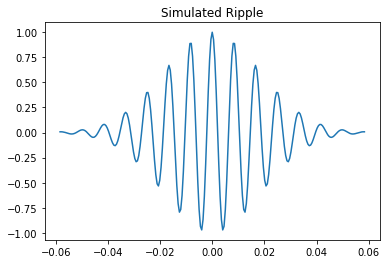

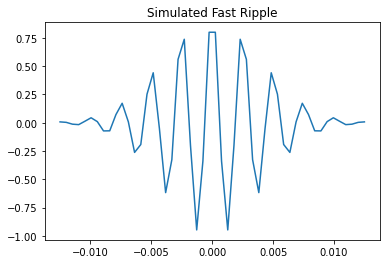

In [4]:
fig = plt.figure()
ax = plt.axes()
ax.plot(ripple_time, ripple_data)
plt.title("Simulated Ripple")

fig = plt.figure()
ax = plt.axes()
ax.plot(fast_ripple_time, fast_ripple_data)
plt.title("Simulated Fast Ripple")

### 1.1.2 Add other "simulated" EEG data
These detectors work by finding patterns that deviate from the normal, so we need some "normal" EEG attached to the simulated HFO signal for the detectors to work. We can do this by grabbing a small segment of real EEG data from mne's samples.

In [5]:
%%capture
# Load in template data
data_path = sample.data_path()
raw_fname = data_path + '/MEG/sample/sample_audvis_raw.fif'
fwd_fname = data_path + '/MEG/sample/sample_audvis-meg-eeg-oct-6-fwd.fif'

# Load real data as the template
raw = mne.io.read_raw_fif(raw_fname)
raw.set_eeg_reference(projection=True)
raw = raw.pick_channels(['EEG 001'])
sfreq = int(np.round(raw.info['sfreq']))
# Get two seconds of data to add before and after the HFO
raw_data_front = raw.get_data(start=0, stop=2*sfreq)[0]
raw_data_back = raw.get_data(start=2*sfreq, stop=4*sfreq)[0]
times = np.linspace(0, 2, 2*sfreq)

Text(0.5, 1.0, 'Raw Data Sample (Back)')

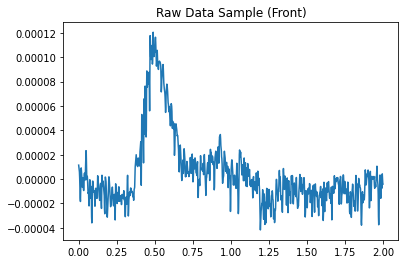

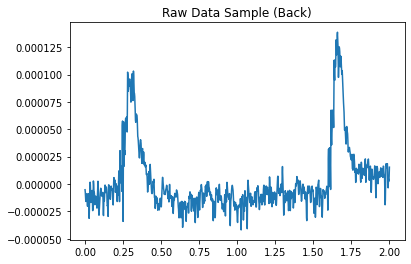

In [6]:
# Visualize the raw data
fig = plt.figure()
ax = plt.axes()
ax.plot(times, raw_data_front)
plt.title("Raw Data Sample (Front)")

fig = plt.figure()
ax = plt.axes()
ax.plot(times, raw_data_back)
plt.title("Raw Data Sample (Back)")
#plt.plot(times, raw_data_back)

### 1.1.3 Combine the simulated data with sample data
Append the data to the front and back of the simulated HFOs

In [7]:
def change_scale(val, aim_min, aim_max, cur_min, cur_max):
    return (val - cur_min) * (aim_max - aim_min) / (cur_max - cur_min) + aim_min

In [8]:
# Normalize ripple data scale to that of the sample data
sig_min = np.min([np.min(raw_data_front), np.min(raw_data_back)])
sig_max = np.max([np.max(raw_data_front), np.max(raw_data_back)])
ripple_min = np.min(ripple_data)
ripple_max = np.max(ripple_data)
fast_ripple_min = np.min(fast_ripple_data)
fast_ripple_max = np.max(fast_ripple_data)

ripple_data = [change_scale(r, sig_min, sig_max, ripple_min, ripple_max) for r in ripple_data]
fast_ripple_data = [change_scale(r, sig_min, sig_max, fast_ripple_min, fast_ripple_max) for r in fast_ripple_data]

In [9]:
# Combine the datasets and create new time vectors
ripple_data_total = np.concatenate((raw_data_front, ripple_data, raw_data_back))
t_total = len(raw_data_front) + len(ripple_data) + len(raw_data_back)
ripple_times_total = np.linspace(0, t_total/sfreq, t_total)

fast_ripple_data_total = np.concatenate((raw_data_front, fast_ripple_data, raw_data_back))
fast_t_total = len(raw_data_front) + len(fast_ripple_data) + len(raw_data_back)
fast_ripple_times_total = np.linspace(0, fast_t_total/sfreq, fast_t_total)


Text(0.5, 1.0, 'Simulated data with Fast Ripple')

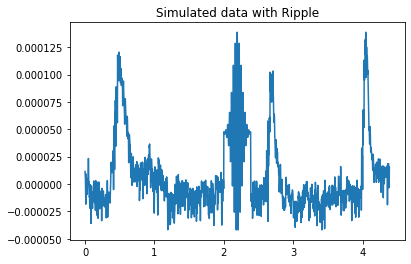

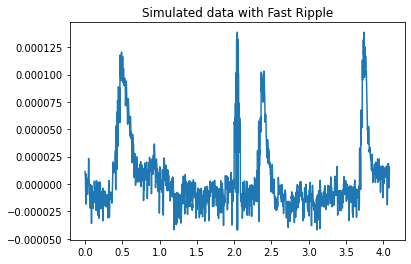

In [10]:
# Visualize
fig = plt.figure()
ax = plt.axes()
ax.plot(ripple_times_total, ripple_data_total)
plt.title("Simulated data with Ripple")

fig = plt.figure()
ax = plt.axes()
ax.plot(fast_ripple_times_total, fast_ripple_data_total)
plt.title("Simulated data with Fast Ripple")

In [11]:
# Reshape the data to fit detector requirements
ripple_data_total = ripple_data_total.reshape(1, len(ripple_data_total))
fast_ripple_data_total = fast_ripple_data_total.reshape(1, len(fast_ripple_data_total))

## 1.2 Detect the HFOs

We have two detectors that can detect the presence of an HFO, a LineLengthDetector and an RMSDetector. We will plug the simulated data into each detector to demonstrate the presence of HFOs.

### 1.2.1 Line Length Detector

In [12]:
# Set Key Word Arguments for the Line Length Detector and generate the class object
kwargs = {
    'filter_band': (80, 250), # (l_freq, h_freq)
    'threshold': 3, # Number of st. deviations
    'win_size': 100, # Sliding window size in samples
    'overlap': 0.25, # Fraction of window overlap [0, 1]
    'sfreq': 2000,  # Sampling frequency of data
}
ll_detector = LineLengthDetector(**kwargs)

In [13]:
%%capture
# Detect HFOs in the raw data using the LineLengthDetector method.
# Return the class object with HFOs added
ll_detector = ll_detector.fit(ripple_data_total)

# Dictionary where keys are channel index and values are a list of tuples in the form of (start_samp, end_samp)
chs_hfo_dict = ll_detector.chs_hfos_ 
# nCh x nWin ndarray where each value is the line-length of the data window per channel
hfo_event_array = ll_detector.hfo_event_arr_
# Pandas dataframe containing onset, duration, sample trial, and trial type per HFO
hfo_df = ll_detector.df_

### 1.2.2 Check Results
We should see a single HFO starting around 2 seconds and ending a small amount after

In [14]:
detected_hfos = chs_hfo_dict.get("0")
for hfo in detected_hfos:
    start_samp = hfo[0]
    end_samp = hfo[1]
    start_time = start_samp / sfreq
    end_time = end_samp / sfreq
    print(f"Detected a ripple HFO starting at {start_time}s and ending at {end_time}s")

Detected a ripple HFO starting at 2.0798668885191347s and ending at 2.4126455906821964s


### 1.2.3 Repeat for RMS Detector
We should get almost the exact same result

In [15]:
%%capture
# Set Key Word Arguments for the Line Length Detector and generate the class object
kwargs = {
    'filter_band': (80, 250),
    'threshold': 3,
    'win_size': 100,
    'overlap': 0.25,
    'sfreq': 2000,
}
rms_detector = RMSDetector(**kwargs)
rms_detector = rms_detector.fit(ripple_data_total)
chs_hfo_dict = rms_detector.chs_hfos_ 

In [16]:
detected_hfos = chs_hfo_dict.get("0")
for hfo in detected_hfos:
    start_samp = hfo[0]
    end_samp = hfo[1]
    start_time = start_samp / sfreq
    end_time = end_samp / sfreq
    print(f"Detected a ripple HFO starting at {start_time}s and ending at {end_time}s")

Detected a ripple HFO starting at 2.0798668885191347s and ending at 2.4126455906821964s


### 1.2.4 Repeat for the fast ripple dataset
We should expect similar results

In [17]:
%%capture
# Line length Detector
kwargs = {
    'filter_band': (250, 500),
    'threshold': 3,
    'win_size': 100,
    'overlap': 0.25,
    'sfreq': 2000,
}
ll_detector = LineLengthDetector(**kwargs)
ll_detector = ll_detector.fit(fast_ripple_data_total)
ll_chs_hfo_dict = ll_detector.chs_hfos_ 

# RMS detector
rms_detector = RMSDetector(**kwargs)
rms_detector = rms_detector.fit(fast_ripple_data_total)
rms_chs_hfo_dict = rms_detector.chs_hfos_ 

In [18]:
detected_hfos = ll_chs_hfo_dict.get("0")
for hfo in detected_hfos:
    start_samp = hfo[0]
    end_samp = hfo[1]
    start_time = start_samp / sfreq
    end_time = end_samp / sfreq
    print(f"Detected a fast ripple HFO starting at {start_time}s and ending at {end_time}s using the LineLength Detector")

detected_hfos = rms_chs_hfo_dict.get("0")
for hfo in detected_hfos:
    start_samp = hfo[0]
    end_samp = hfo[1]
    start_time = start_samp / sfreq
    end_time = end_samp / sfreq
    print(f"Detected a fast ripple HFO starting at {start_time}s and ending at {end_time}s using the RMS detector")

Detected a fast ripple HFO starting at 1.9550748752079867s and ending at 2.2462562396006653s using the LineLength Detector
Detected a fast ripple HFO starting at 1.9550748752079867s and ending at 2.2462562396006653s using the RMS detector


### 1.2.5 More complex Example
Now let's combine the two datasets to show how the detectors differentiate the ripple types.

The detectors set to the ripple frequency band (80-250Hz) should only detect a single HFO (ripple) around the 2 second mark. The detectors set to the fast ripple frequency band (250-500Hz) should only detect a single HFO (fast ripple) around the 6 second mark (will vary based on the length of the ripple wave added).

Text(0.5, 1.0, 'Simulated data with Ripple and Fast Ripple')

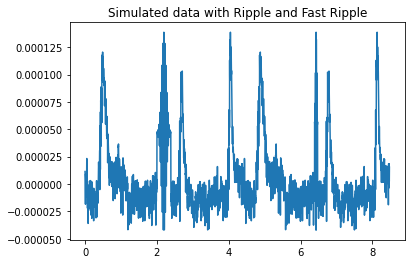

In [19]:
# Combine
hfo_data_total = np.concatenate((ripple_data_total, fast_ripple_data_total), axis=1)
hfo_times_total = np.linspace(0, hfo_data_total.shape[1]/sfreq, hfo_data_total.shape[1])

# Reshape just for plotting
hfo_data_total_plot = hfo_data_total.reshape(hfo_data_total.shape[1], 1)

# Plot
fig = plt.figure()
ax = plt.axes()
ax.plot(hfo_times_total, hfo_data_total_plot)
plt.title("Simulated data with Ripple and Fast Ripple")

In [20]:
%%capture
# First look for ripples
# Line length Detector
kwargs = {
    'filter_band': (80, 250),
    'threshold': 3,
    'win_size': 100,
    'overlap': 0.25,
    'sfreq': 2000,
}
ll_detector = LineLengthDetector(**kwargs)
ll_detector = ll_detector.fit(hfo_data_total)
ll_chs_hfo_dict = ll_detector.chs_hfos_ 

# RMS detector
rms_detector = RMSDetector(**kwargs)
rms_detector = rms_detector.fit(hfo_data_total)
rms_chs_hfo_dict = rms_detector.chs_hfos_ 

# Then look for fast ripples
# Line length Detector
kwargs = {
    'filter_band': (250, 500),
    'threshold': 3,
    'win_size': 100,
    'overlap': 0.25,
    'sfreq': 2000,
}
ll_detector = LineLengthDetector(**kwargs)
ll_detector = ll_detector.fit(hfo_data_total)
ll_fr_chs_hfo_dict = ll_detector.chs_hfos_ 

# RMS detector
rms_detector = RMSDetector(**kwargs)
rms_detector = rms_detector.fit(hfo_data_total)
rms_fr_chs_hfo_dict = rms_detector.chs_hfos_ 


In [21]:
detected_hfos = ll_chs_hfo_dict.get("0")
for hfo in detected_hfos:
    start_samp = hfo[0]
    end_samp = hfo[1]
    start_time = start_samp / sfreq
    end_time = end_samp / sfreq
    print(f"Detected a ripple HFO starting at {start_time}s and ending at {end_time}s using the LineLength Detector")
    


detected_hfos = rms_chs_hfo_dict.get("0")
for hfo in detected_hfos:
    start_samp = hfo[0]
    end_samp = hfo[1]
    start_time = start_samp / sfreq
    end_time = end_samp / sfreq
    print(f"Detected a ripple HFO starting at {start_time}s and ending at {end_time}s using the RMS detector")
    
detected_hfos = ll_fr_chs_hfo_dict.get("0")
for hfo in detected_hfos:
    start_samp = hfo[0]
    end_samp = hfo[1]
    start_time = start_samp / sfreq
    end_time = end_samp / sfreq
    print(f"Detected a fast ripple HFO starting at {start_time}s and ending at {end_time}s using the LineLength Detector")
    

detected_hfos = rms_fr_chs_hfo_dict.get("0")
for hfo in detected_hfos:
    start_samp = hfo[0]
    end_samp = hfo[1]
    start_time = start_samp / sfreq
    end_time = end_samp / sfreq
    print(f"Detected a fast ripple HFO starting at {start_time}s and ending at {end_time}s using the RMS detector")

Detected a ripple HFO starting at 2.0798668885191347s and ending at 2.4126455906821964s using the LineLength Detector
Detected a ripple HFO starting at 2.0798668885191347s and ending at 2.4126455906821964s using the RMS detector
Detected a fast ripple HFO starting at 6.364392678868552s and ending at 6.613976705490849s using the LineLength Detector
Detected a fast ripple HFO starting at 6.364392678868552s and ending at 6.613976705490849s using the RMS detector
